# Mixed Reversal + Momentum — Walk-Forward Validation

We validate an **equal-volatility mix** of cross-sectional **Reversal** (daily rebalance) and **Momentum** (monthly rebalance) on hourly crypto data using **expanding** and **rolling** walk-forward splits. We report out-of-sample (OOS) performance, **alpha/beta vs BTC**, and **cost sensitivity** at 7/10/20 bps.

In [19]:
# --- Core ---
import numpy as np
import pandas as pd
from pathlib import Path
from itertools import product
import matplotlib.pyplot as plt
import sys

# --- Display ---
pd.set_option("display.width", 160)
pd.set_option("display.max_columns", 200)

# --- Paths ---
PROJECT_ROOT = Path.cwd().parent          # .../crypto-stat-arb
SRC_DIR = PROJECT_ROOT / "src"            # .../crypto-stat-arb/src
PKG_DIR = SRC_DIR / "crypto_stat_arb"     # .../crypto-stat-arb/src/crypto_stat_arb
DATA_DIR = SRC_DIR / "data"               # .../crypto-stat-arb/src/data

# Make the package importable
if str(SRC_DIR) not in sys.path:
    sys.path.insert(0, str(SRC_DIR))

# --- Config ---
from crypto_stat_arb.config import ANNUALIZATION, COST_BPS, COST_RATE
from crypto_stat_arb.io import load_panels
from crypto_stat_arb.signals import cs_momentum_weights, cs_reversal_weights
from crypto_stat_arb.portfolio import downsample_weights
from crypto_stat_arb.backtest import backtest, perf_stats
from crypto_stat_arb.stats import rolling_sharpe, perf_summary_from_series_exact, compute_alpha_beta
from crypto_stat_arb.walkforward import run_walk_forward_mixed

print("PROJECT_ROOT:", PROJECT_ROOT)
print("SRC_DIR:", SRC_DIR)
print("PKG_DIR exists:", PKG_DIR.exists())
print("DATA_DIR:", DATA_DIR)
print("ANNUALIZATION:", ANNUALIZATION, "| COST_BPS:", COST_BPS, "| COST_RATE:", COST_RATE)

PROJECT_ROOT: C:\Users\Cameron Collins\crypto-stat-arb
SRC_DIR: C:\Users\Cameron Collins\crypto-stat-arb\src
PKG_DIR exists: True
DATA_DIR: C:\Users\Cameron Collins\crypto-stat-arb\src\data
ANNUALIZATION: 8760 | COST_BPS: 7 | COST_RATE: 0.0007


In [20]:
# Load price/return panels via helper
px, ret = load_panels(DATA_DIR)

print("Coverage window:", ret.index.min(), "→", ret.index.max(), f"({len(ret):,} bars)")
print("N assets:", ret.shape[1])
print("Max NA frac:", float(ret.isna().mean().max()))

if ret.isna().any().any():
    ret = ret.ffill().dropna(how="any")
    px  = px.loc[ret.index, ret.columns]
    print("After fill/drop:", ret.shape)

BENCH = "BTCUSDT" if "BTCUSDT" in ret.columns else None

Coverage window: 2023-01-01 01:00:00+00:00 → 2025-08-14 00:00:00+00:00 (22,944 bars)
N assets: 12
Max NA frac: 0.0


Expanding folds: 6 | mean test Sharpe: 2.321 | median: 2.352
Rolling   folds: 6 | mean test Sharpe: 2.345 | median: 2.352


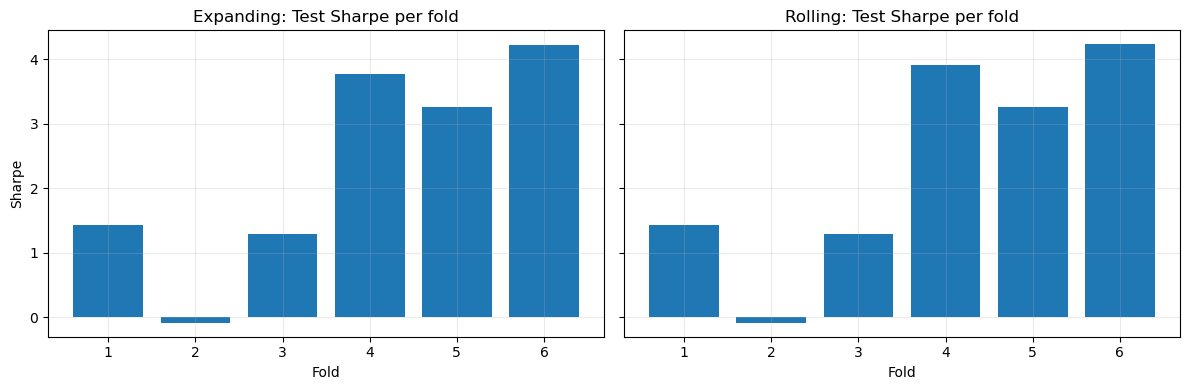

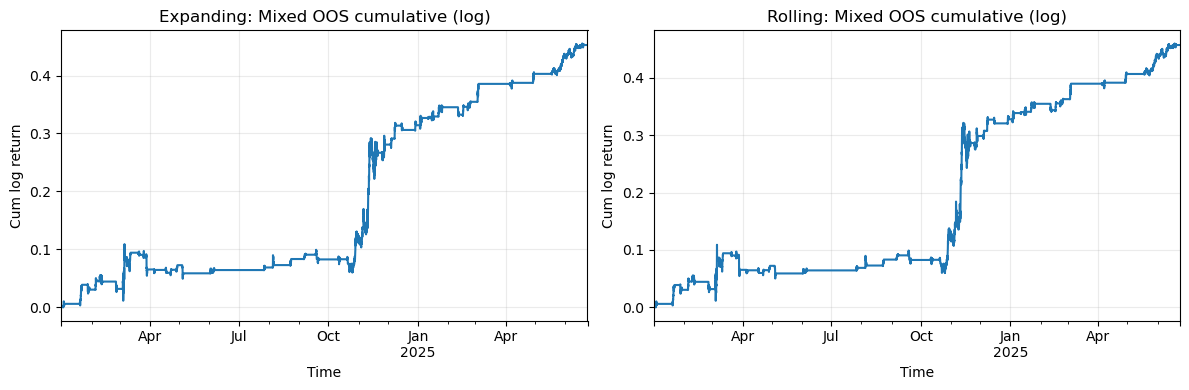

In [21]:
# --- Strategy params ---
params_rev = {"k": 4, "band": 2.5, "beta_win": 168, "vol_win": 24}
params_mom = {"k": 400, "band": 2.5, "beta_win": None, "vol_win": None}
every_rev = 24
every_mom = 720

# --- Expanding ---
exp_df_mix, exp_oos_mix = run_walk_forward_mixed(
    ret,
    params_rev, params_mom,
    every_rev=every_rev, every_mom=every_mom,
    mix_mode="equal_vol",
    train_days=365, test_days=90, mode="expanding",
    cost_bps=COST_BPS,
    reversal_func=cs_reversal_weights,   # <-- provide functions
    momentum_func=cs_momentum_weights,   # <--
)

# --- Rolling ---
roll_df_mix, roll_oos_mix = run_walk_forward_mixed(
    ret,
    params_rev, params_mom,
    every_rev=every_rev, every_mom=every_mom,
    mix_mode="equal_vol",
    train_days=365, test_days=90, mode="rolling",
    cost_bps=COST_BPS,
    reversal_func=cs_reversal_weights,   # <-- provide functions
    momentum_func=cs_momentum_weights,   # <--
)

print(
    "Expanding folds:", len(exp_df_mix),
    "| mean test Sharpe:", round(float(exp_df_mix["test_sharpe"].mean()), 3),
    "| median:", round(float(exp_df_mix["test_sharpe"].median()), 3),
)
print(
    "Rolling   folds:", len(roll_df_mix),
    "| mean test Sharpe:", round(float(roll_df_mix["test_sharpe"].mean()), 3),
    "| median:", round(float(roll_df_mix["test_sharpe"].median()), 3),
)

# --- Plots: per-fold Sharpe + stitched OOS cumulative (log) ---
fig, ax = plt.subplots(1, 2, figsize=(12,4), sharey=True)
ax[0].bar(exp_df_mix["fold"], exp_df_mix["test_sharpe"]); ax[0].set_title("Expanding: Test Sharpe per fold")
ax[0].set_xlabel("Fold"); ax[0].set_ylabel("Sharpe"); ax[0].grid(True, alpha=0.25)
ax[1].bar(roll_df_mix["fold"], roll_df_mix["test_sharpe"]); ax[1].set_title("Rolling: Test Sharpe per fold")
ax[1].set_xlabel("Fold"); ax[1].grid(True, alpha=0.25)
plt.tight_layout(); plt.show()

fig, ax = plt.subplots(1, 2, figsize=(12,4))
exp_oos_mix.fillna(0).cumsum().plot(ax=ax[0]); ax[0].set_title("Expanding: Mixed OOS cumulative (log)")
ax[0].set_xlabel("Time"); ax[0].set_ylabel("Cum log return"); ax[0].grid(True, alpha=0.25)
roll_oos_mix.fillna(0).cumsum().plot(ax=ax[1]); ax[1].set_title("Rolling: Mixed OOS cumulative (log)")
ax[1].set_xlabel("Time"); ax[1].set_ylabel("Cum log return"); ax[1].grid(True, alpha=0.25)
plt.tight_layout(); plt.show()

Cost 7 bps → Exp mean Sharpe=2.32, Roll mean Sharpe=2.34
Cost 10 bps → Exp mean Sharpe=2.19, Roll mean Sharpe=2.22
Cost 20 bps → Exp mean Sharpe=1.77, Roll mean Sharpe=1.80


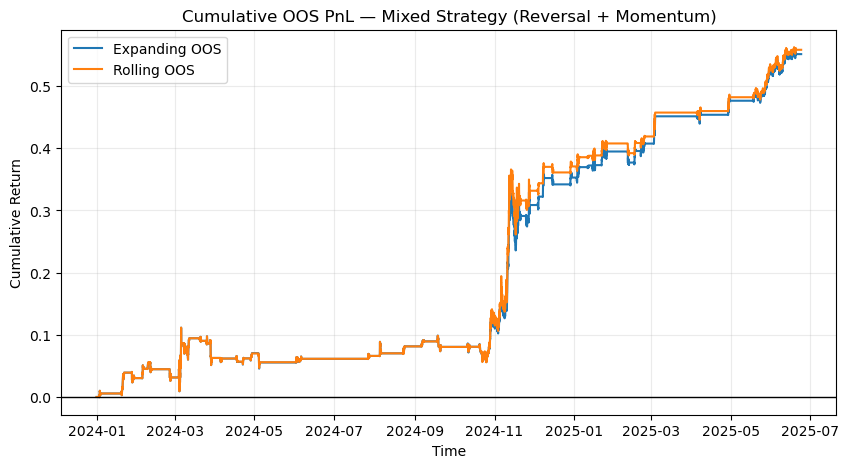

,ann_ret,ann_vol,sharpe
label,,,
Expanding,0.306,0.136,2.250
Rolling,0.309,0.137,2.263


In [22]:
# --- Cost sensitivity for the mixed strategy (equal-vol mix) ---
for bps in [7, 10, 20]:
    df_e, _ = run_walk_forward_mixed(
        ret, params_rev, params_mom,
        every_rev=every_rev, every_mom=every_mom,
        mix_mode="equal_vol",
        train_days=365, test_days=90, mode="expanding",
        cost_bps=bps,
        reversal_func=cs_reversal_weights,
        momentum_func=cs_momentum_weights,
    )
    df_r, _ = run_walk_forward_mixed(
        ret, params_rev, params_mom,
        every_rev=every_rev, every_mom=every_mom,
        mix_mode="equal_vol",
        train_days=365, test_days=90, mode="rolling",
        cost_bps=bps,
        reversal_func=cs_reversal_weights,
        momentum_func=cs_momentum_weights,
    )
    print(
        f"Cost {bps} bps → Exp mean Sharpe={df_e['test_sharpe'].mean():.2f}, "
        f"Roll mean Sharpe={df_r['test_sharpe'].mean():.2f}"
    )

# --- Summaries using stitched OOS series ---
def _row(series, label):
    d = perf_stats(series.dropna())
    return {"label": label, "ann_ret": d.get("ann_ret"), "ann_vol": d.get("ann_vol"), "sharpe": d.get("sharpe")}

summary_df = pd.DataFrame([
    _row(exp_oos_mix,  "Expanding"),
    _row(roll_oos_mix, "Rolling"),
]).set_index("label")

# --- Plot cumulative OOS PnL (Expanding vs Rolling) ---
fig, ax = plt.subplots(figsize=(10, 5))
for name, oos in [("Expanding", exp_oos_mix), ("Rolling", roll_oos_mix)]:
    cum_pnl = (1 + oos.dropna()).cumprod() - 1   # cumulative simple return
    ax.plot(cum_pnl.index, cum_pnl.values, label=f"{name} OOS")

ax.axhline(0, color="black", lw=1)
ax.set_title("Cumulative OOS PnL — Mixed Strategy (Reversal + Momentum)")
ax.set_ylabel("Cumulative Return")
ax.set_xlabel("Time")
ax.legend()
ax.grid(True, alpha=0.25)
plt.show()

display(summary_df.round(3))

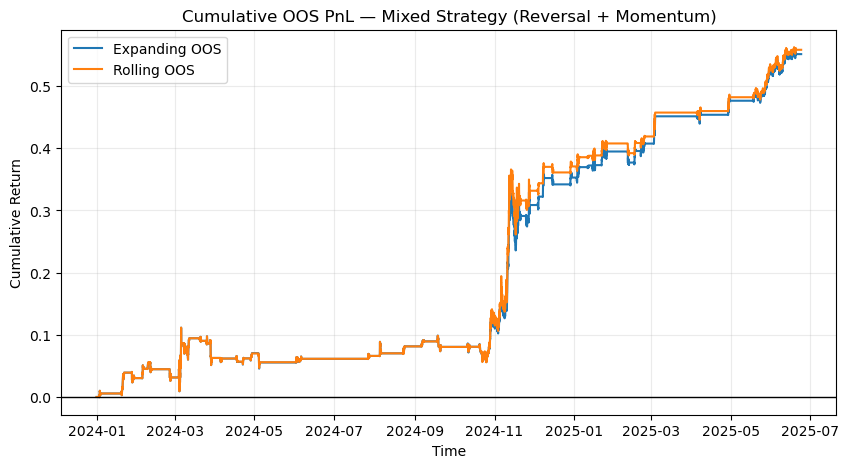

,ann_ret,ann_vol,sharpe,max_dd
label,,,,
Expanding,0.346,0.136,2.540,-0.069
Rolling,0.350,0.137,2.559,-0.077


In [23]:
# ---- Summaries using stitched OOS series
summary_df = pd.DataFrame([
    perf_summary_from_series_exact(exp_oos_mix,  "Expanding"),
    perf_summary_from_series_exact(roll_oos_mix, "Rolling"),
]).set_index("label")

# ---- Plot cumulative OOS PnL (Expanding vs Rolling)
fig, ax = plt.subplots(figsize=(10, 5))
for name, oos in [("Expanding", exp_oos_mix), ("Rolling", roll_oos_mix)]:
    cum_pnl = (1 + oos.dropna()).cumprod() - 1
    ax.plot(cum_pnl.index, cum_pnl.values, label=f"{name} OOS")

ax.axhline(0, color="black", lw=1)
ax.set_title("Cumulative OOS PnL — Mixed Strategy (Reversal + Momentum)")
ax.set_ylabel("Cumulative Return")
ax.set_xlabel("Time")
ax.legend()
ax.grid(True, alpha=0.25)
plt.show()

display(summary_df.round(3))


In [24]:
# --- Benchmark: BTC hourly returns (fallback to cross-sectional mean) ---
bench_ret = ret["BTCUSDT"] if "BTCUSDT" in ret.columns else ret.mean(axis=1)

# --- Stitched OOS series from mixed WF (pick one) ---
mix_oos = roll_oos_mix   # or: exp_oos_mix

# --- Alpha/Beta vs benchmark with HAC (Newey–West) SEs ---
# match earlier HAC horizon (~1 month of hourly bars)
res_mix = compute_alpha_beta(mix_oos, bench_ret, freq=ANNUALIZATION, lag_bars=24*30)

print("Mixed strategy vs benchmark (BTCUSDT if available)")
for k, v in res_mix.items():
    print(f"{k:>10}: {v: .4f}" if isinstance(v, (float, np.floating)) else f"{k:>10}: {v}")

Mixed strategy vs benchmark (BTCUSDT if available)
 alpha_ann:  0.3073
   alpha_t:  2.5362
      beta:  0.0032
    beta_t:  0.1883
        R2:  0.0001
     n_obs: 12960


In [25]:
# --- Stitched OOS series ---
series_map = {
    "Expanding OOS": exp_oos_mix,   # stitched OOS net returns
    "Rolling OOS":   roll_oos_mix,
}

# HAC lag: tie to slower sleeve cadence (momentum); default to 720 if not defined
try:
    hac_lag = max(24, int(every_mom))
except NameError:
    hac_lag = 720

rows = []
for label, r in series_map.items():
    # compute_alpha_beta returns: alpha_ann, alpha_t, beta, beta_t, R2, n_obs
    res = compute_alpha_beta(r, bench_ret, freq=ANNUALIZATION, lag_bars=hac_lag)
    res["label"] = label
    rows.append(res)

alpha_beta_df = pd.DataFrame(rows).set_index("label").round(3)

display(alpha_beta_df)

,alpha_ann,alpha_t,beta,beta_t,R2,n_obs
label,,,,,,
Expanding OOS,0.306,2.697,0.001,0.036,0.0,12960
Rolling OOS,0.307,2.536,0.003,0.188,0.0,12960


## Results & Interpretation

### OOS performance (stitched, net of costs)
- **Expanding:** **Sharpe 2.54**, ann. return **0.346**, ann. vol **0.136**, **max DD −6.9%**  
- **Rolling:**   **Sharpe 2.56**, ann. return **0.350**, ann. vol **0.137**, **max DD −7.7%**

> Both schemes deliver **very high OOS Sharpe (~2.5)** with shallow drawdowns for a mixed sleeve running at equal-vol risk.

### Alpha/Beta vs BTC (HAC / Newey–West)
Using **12,960 hourly obs** (≈540 days):
- Mixed strategy (headline): **α_ann ≈ 0.307**, **t(α) ≈ 2.54**  
  **β ≈ 0.003**, **t(β) ≈ 0.19**, **R² ≈ 0.0001**, **n = 12,960**
- By split:
  - **Expanding OOS:** α_ann ≈ **0.306**, t ≈ **2.70**, β ≈ **0.001**, t ≈ **0.04**, R² ≈ **0.0000**, n = **12,960**
  - **Rolling OOS:**   α_ann ≈ **0.307**, t ≈ **2.54**, β ≈ **0.003**, t ≈ **0.19**, R² ≈ **0.0000**, n = **12,960**

**Takeaway:** Statistically significant **positive alpha** versus BTC, with **beta ~ 0** and **near-zero R²** → the mixed sleeve is essentially **orthogonal** to BTC’s returns.

### Cost sensitivity (equal-vol mix)
- **7 bps:**  Exp mean Sharpe **2.32**, Roll mean Sharpe **2.34**  
- **10 bps:** Exp **2.19**, Roll **2.22**  
- **20 bps:** Exp **1.77**, Roll **1.80**

**Takeaway:** Performance degrades with higher costs (as expected), but remains **strong** even at **20 bps**, helped by the momentum sleeve’s very low turnover and the mix’s diversification.

---

### Overall conclusions
- The **equal-vol mix of Reversal + Momentum** achieves **robust, high OOS Sharpe (~2.5)** with **modest drawdowns (<8%)**.
- **Alpha vs BTC** is **positive and significant**; **beta is negligible**, confirming the sleeve provides **diversified crypto exposure** rather than simple market beta.
- The strategy is **cost-resilient** across realistic fee bands; still attractive at **20 bps**.
- For deployment, the mix offers a compelling **risk-adjusted return** profile: Reversal contributes high-frequency edge, Momentum supplies low-cost persistence, and their **low correlation** unlocks the Sharpe gain.

*Limitations:* Results are based on 22,900 hourly bars (~2.6 years) and a fixed 12-asset universe; this short, recent sample limits regime coverage and statistical power. Trading costs are simplified, and outcomes depend on benchmark choice and parameter search—treat these as indicative, not definitive.
